# 数据

## 数据预览

In [74]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

data_dir = r'C:\Users\16654\Desktop\train\dataset2'
classes = os.listdir(data_dir)
print(classes)

['切菜板', '剩菜剩饭', '包', '厨余五捧花', '厨具一锅', '厨具三铲勺', '塑料瓶', '塑料瓶一矿泉水食用油', '塑料瓶一立白', '塑料瓶三洗发洗澡', '塑料瓶二化妆品', '塑料袋', '床褥枕头', '废弃医疗包装', '废纸一报纸', '废纸三书本', '废纸三纸巾', '废纸二纸箱', '废纸五卡牌', '废纸六快递包装', '排插', '易拉罐', '果蔬', '灯泡', '烟头', '牙签', '玩具', '玻璃杯瓶', '电子产品一充电宝', '电子产品三', '电子产品九电脑', '电子产品二充电器', '电子产品五电热水壶', '电子产品八空调风扇', '电子产品六电池', '电子产品十一U盘', '电子产品十三电子手环', '电子产品十二电饭煲', '电子产品十四鼠标', '电子产品十头戴耳机', '电子产品四电线插头', '盆', '笔', '筷子', '纸盒一饮料', '纸盒二药品', '罐头', '蛋', '衣服', '衣架', '陶瓷碗', '鞋子']


In [75]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform=transformations)
len(dataset)

45352

Label: 切菜板 (Class No: 0)


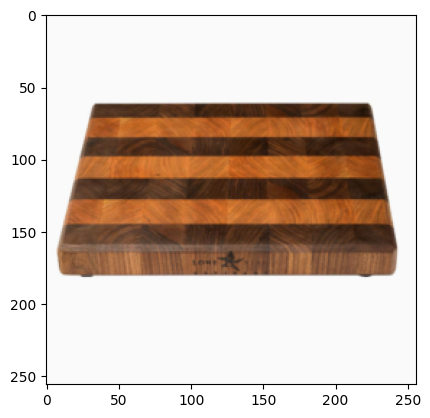

In [76]:
import matplotlib.pyplot as plt


def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))


img, label = dataset[12]
show_sample(img, label)

## 数据加载和分割

In [77]:
random_seed = 42
torch.manual_seed(random_seed)

# 划分训练集 验证集 测试集
total_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(31746, 4535, 9071)

## 数据加载器(训练和验证)

In [78]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

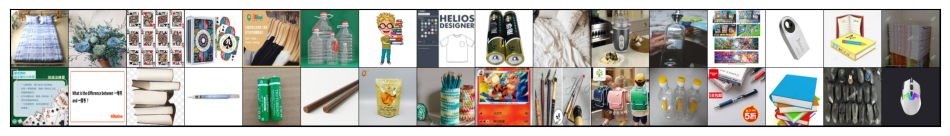

In [79]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dl)

# 模型

In [80]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))


class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))


model = ResNet()

# 设备

In [81]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
device

device(type='cuda')

In [82]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# 模型训练

In [83]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model = to_device(ResNet(), device)
evaluate(model, val_dl)

{'val_loss': 3.9417378902435303, 'val_acc': 0.018705986440181732}

In [84]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 3.2023, val_loss: 3.0702, val_acc: 0.8548
Epoch 2: train_loss: 3.0530, val_loss: 3.0453, val_acc: 0.8784
Epoch 3: train_loss: 3.0290, val_loss: 3.0379, val_acc: 0.9021
Epoch 4: train_loss: 3.0183, val_loss: 3.0408, val_acc: 0.8936
Epoch 5: train_loss: 3.0143, val_loss: 3.0375, val_acc: 0.9057
Epoch 6: train_loss: 3.0087, val_loss: 3.0343, val_acc: 0.9158
Epoch 7: train_loss: 3.0084, val_loss: 3.0357, val_acc: 0.9059
Epoch 8: train_loss: 3.0054, val_loss: 3.0336, val_acc: 0.9163
Epoch 9: train_loss: 3.0040, val_loss: 3.0356, val_acc: 0.9134
Epoch 10: train_loss: 3.0016, val_loss: 3.0374, val_acc: 0.9108
Epoch 11: train_loss: 3.0002, val_loss: 3.0348, val_acc: 0.9187
Epoch 12: train_loss: 2.9986, val_loss: 3.0296, val_acc: 0.9229
Epoch 13: train_loss: 2.9996, val_loss: 3.0426, val_acc: 0.9034
Epoch 14: train_loss: 2.9984, val_loss: 3.0360, val_acc: 0.9129
Epoch 15: train_loss: 2.9986, val_loss: 3.0368, val_acc: 0.9108
Epoch 16: train_loss: 2.9965, val_loss: 3.0361, v

## 训练结果曲线

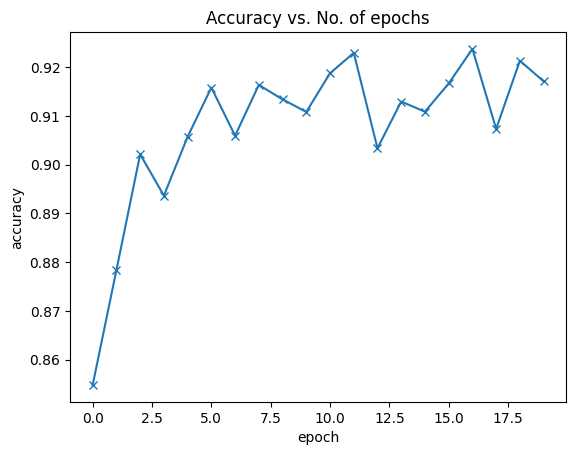

In [85]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


plot_accuracies(history)

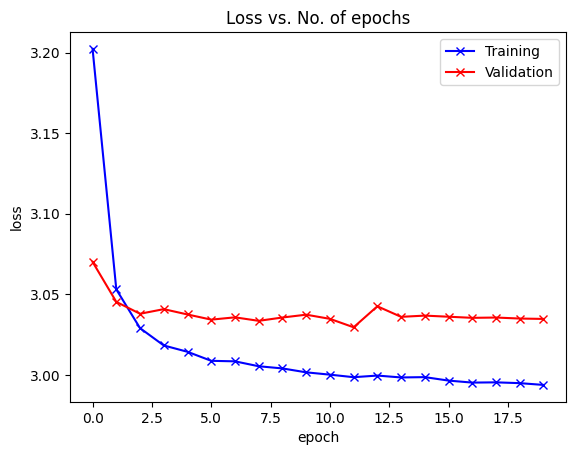

In [86]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


plot_losses(history)

# 预测测试集

In [87]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: 电子产品十四鼠标 , Predicted: 电子产品十四鼠标


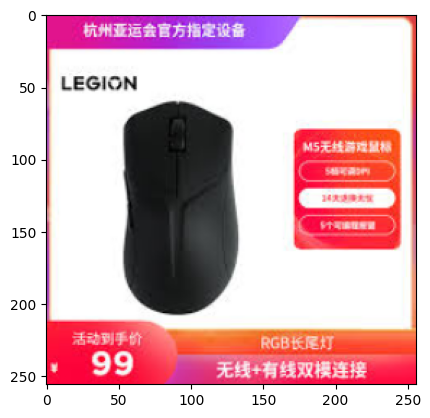

In [92]:
img, label = test_ds[1733]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 废纸三书本 , Predicted: 废纸三书本


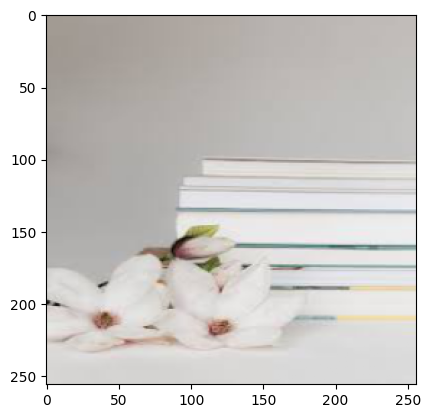

In [93]:
img, label = test_ds[2301]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 电子产品十三电子手环 , Predicted: 电子产品十三电子手环


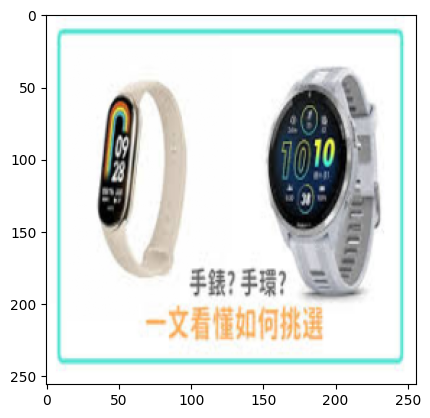

In [90]:
img, label = test_ds[514]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))